In [1]:
import os
import errno
import random
import shutil
import zipfile
import skimage.io as io

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_sample
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
base_dir = '/data/tyler/190808_DCISCOHORT/'

In [3]:
# if not already in .npy format, create it here
folders = os.listdir(base_dir)
folders = [folder for folder in folders if 'Point' in folder]
folders.sort()

# load all data into a single numpy array
data = np.zeros((len(folders), 1024, 1024, 1), dtype='float32')
for i in range(len(folders)):
    data[i, :, :, 0] = io.imread(os.path.join(base_dir, folders[i], 'TIFs/HH3.tif'))
    #data[i, :, :, 1] = io.imread(os.path.join(base_dir, folders[i], 'Cell_Border_Channel.tif'))
    
eval_data = data

In [4]:
np.save(base_dir + 'Nuclear_Channel_Input', data)

In [10]:
CHANNEL_AXIS = 3
# eval_data = np.load(base_dir + "Nuclear_Channel_Input.npy")
eval_data = np.load(base_dir + "Nuclear_Channel_Input.npy")
eval_data = np.expand_dims(eval_data, axis=-1)


In [5]:
MODEL_NAME = 'Point1_12_18_3X_interior_deepcell_old_epoch_30'
weights_path = os.path.join('/data/models/20190505_deepcell_old', 
                            MODEL_NAME + ".h5")

In [6]:
# Load the previously generated weights
# from deepcell import model_zoo

run_sample_model = bn_feature_net_2D(
    n_dense_filters=128,
    n_conv_filters=32,
    dilated=True,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    n_channels=1,    
    input_shape=tuple(eval_data.shape[1:]))

run_sample_model.load_weights(weights_path)

In [7]:
eval_data.shape

(71, 1024, 1024, 1)

In [8]:
model_output = np.zeros((eval_data.shape[0], 1024, 1024, 3))

In [9]:
# process images 10 at a time to avoid running out of memory
decades = (np.floor(eval_data.shape[0] / 10)).astype('int')

for i in range(decades):
    model_output[(i * 10): ((i + 1) * 10), ...] = run_sample_model.predict(eval_data[(i * 10): ((i + 1) * 10), ...])
    print(i * 10, (i + 1) * 10)

# process any remaining images
if eval_data.shape[0] % 10 == 0:
    # do nothing
    print("data is a multiple of 10")
else:
    print("data is not a multiple of 10")
    model_output[(decades * 10):eval_data.shape[0], ...] = run_sample_model.predict(eval_data[(decades * 10):eval_data.shape[0], ...])

0 10
10 20
20 30
30 40
40 50
50 60
60 70
data is not a multiple of 10


In [10]:
np.save(base_dir + 'model_output', model_output)

In [35]:
np.save(base_dir + 'folder_names', folders)

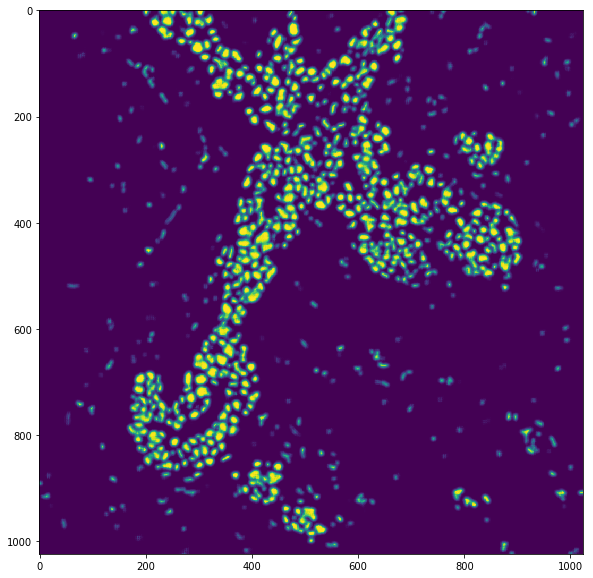

In [33]:
plt.figure(figsize = (10, 10))
plt.imshow(model_output[55, :, :, 1])

In [15]:
# save back to same folder structure
# save images back to folder for viewing from regular network
for i in range(model_ouput.shape[0]):
    if data_deep.shape[-1] == 3:
        # three category network
        border_idx = 0
        nuc_idx = 1
        os.mkdir(os.path.join(base_dir, '20190609_nuc_cnn_output', folders[i]))
        io.imsave(os.path.join(base_dir, '20190524_nuc_cnn_output', folders[i], 'nuc_interior.tiff'), data_deep[i, :, :, nuc_idx])
        #io.imsave(os.path.join(base_dir, '20190520_nuc_border_cnn_output', folders[i], 'nuc_border.tiff'), data_deep[i, :, :, border_idx])


NameError: name 'folders' is not defined

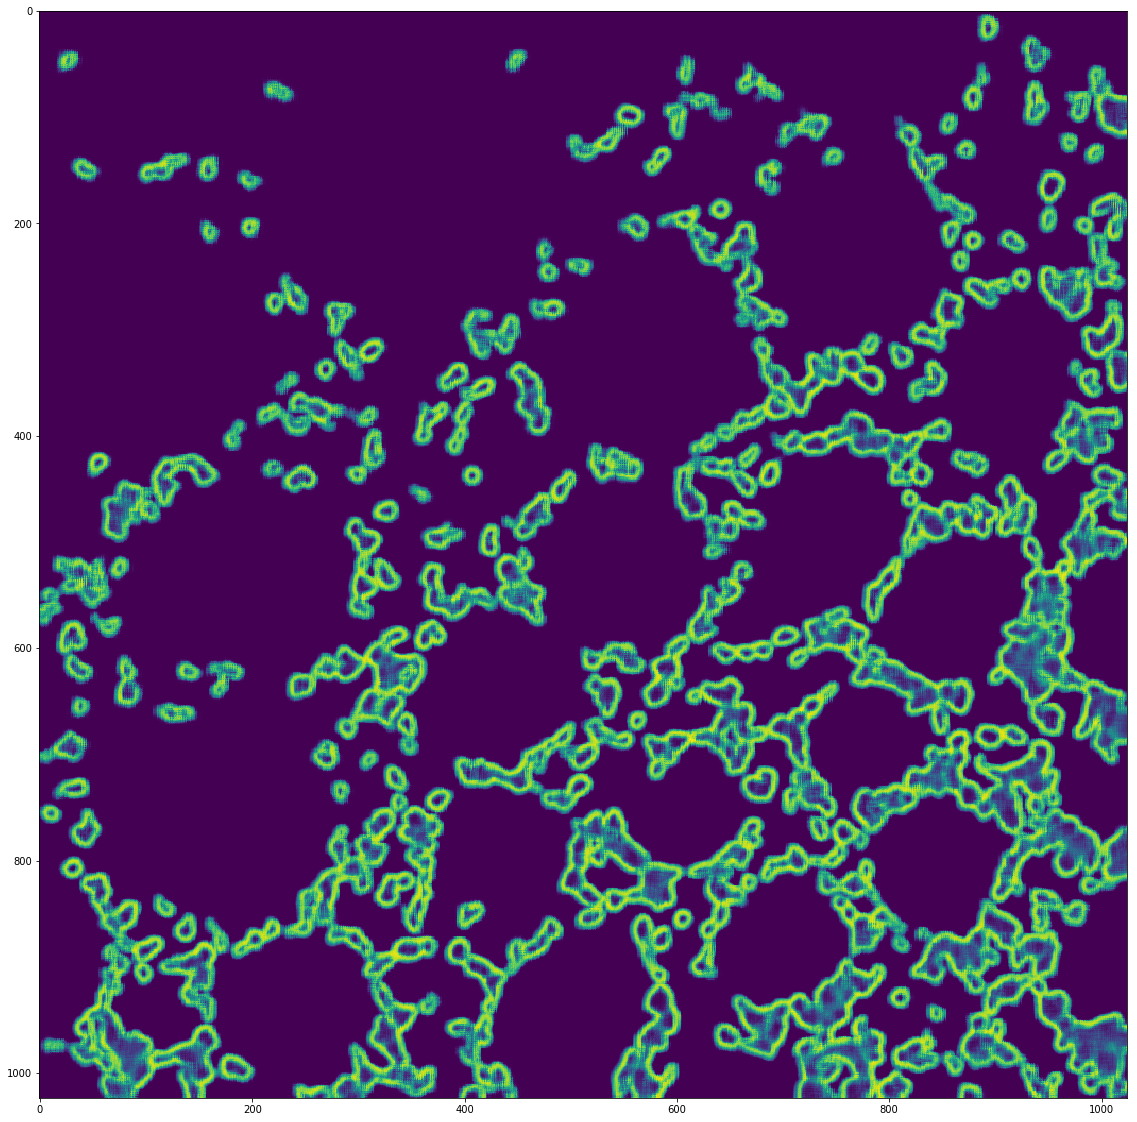

In [25]:
plt.figure(figsize = (20, 20))
# plt.imshow(test_images[2, :, :, 3] - test_2[2, :, :, 3])
# plt.colorbar()
plt.imshow(data_deep[3, :, :, 0])